In [1]:
import os
import cv2
import numpy as np
from imageio import imread, imsave
from matplotlib import pyplot as plt

from skimage.color import rgb2gray
from skimage.morphology import binary_opening, binary_erosion, binary_dilation, binary_closing, remove_small_objects
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.filters import threshold_local, try_all_threshold, threshold_otsu, gaussian
from skimage.measure import regionprops
from skimage.measure import label as sk_measure_label
from scipy.ndimage import binary_fill_holes

In [57]:
def get_largest_component_by_num(mask, num):
    labels = sk_measure_label(mask) # компоненты связности
    props = regionprops(labels) # свойства каждой области
    areas = np.array([prop.area for prop in props]) # площади компонент связности
    
    if num == 0:
        largest_comp_id = np.array(areas).argmax() # находим номер компоненты с максимальной площадью
        return labels == (largest_comp_id + 1) # области нумеруются с 1, поэтому надо прибавить 1 к индексу
    
    areas_copy = areas.copy()
    sorted_indexes = np.array([])

    for i in range(areas.size):
        largest_comp_id = np.array(areas_copy).argmax() # номер компоненты с максимальной площадью
        sorted_indexes = np.append(sorted_indexes, largest_comp_id)
        areas_copy[largest_comp_id] = 0
        if i == num:
            break
        
    largest_comp_id = np.array(areas).argmax() # находим номер компоненты с максимальной площадью

    return labels == (sorted_indexes[num] + 1) # области нумеруются с 1, поэтому надо прибавить 1 к индексу

In [4]:
def bradley_roth_threshold(image):
    img = np.array(image).astype(float)
    width = image.shape[1]
    height = image.shape[0]
    
    # Будем разбивать изображение на прямоугольники со стороной s
    s = np.round(width/8)
    s = s + np.mod(s,2) # если s - нечетное:
    
    # Среднее значение интенсивности в каждом прямоугольнике будем изменять на величину t(%)
    t = 15.0

    # Интегральное изображение
    integral_image = cv2.integral(image)
    
    # Строим сетку пикселей
    (X,Y) = np.meshgrid(np.arange(width), np.arange(height))
    X = X.ravel()
    Y = Y.ravel()

    # Получаем все координаты соседних фрагментов
    x1 = X - s/2
    x2 = X + s/2
    y1 = Y - s/2
    y2 = Y + s/2

    # Поправляем координаты, вышедшие за границы изображения
    x1[x1 < 0] = 0
    x2[x2 >= width] = width - 1
    y1[y1 < 0] = 0
    y2[y2 >= height] = height - 1

    x1 = x1.astype(int)
    x2 = x2.astype(int)
    y1 = y1.astype(int)
    y2 = y2.astype(int)

    # Находим количество пикселей в каждой области
    count = (x2 - x1) * (y2 - y1)

    # Правый нижний фрагмент
    f1_x = x2
    f1_y = y2
    
    # Правый верхний
    f2_x = x2
    f2_y = y1 - 1
    f2_y[f2_y < 0] = 0 # если вышли за границу изображения
    
    # Левый нижний
    f3_x = x1-1
    f3_x[f3_x < 0] = 0 # если вышли за границу изображения
    f3_y = y2
    
    # Левый верхний
    f4_x = f3_x
    f4_y = f2_y

    # Вычисляем сумму значений яркостей по областям
    sums = integral_image[f1_y, f1_x] - integral_image[f2_y, f2_x] - integral_image[f3_y, f3_x] + integral_image[f4_y, f4_x]

    res = np.ones(height * width, dtype=bool)
    res[img.ravel() * count <= sums * (100.0 - t)/100.0] = False

    res = 255 * np.reshape(res, (height, width)).astype(np.uint8)

    return res

## Получим маски для шаблонных изображений

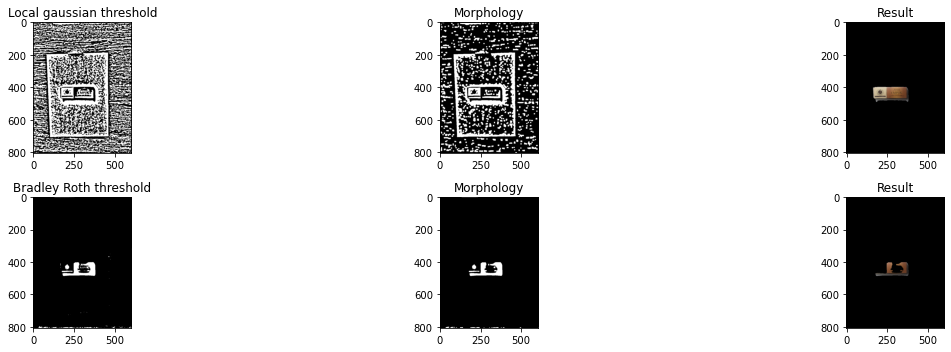

In [36]:
image_path = os.path.join('input\objects', '1_1.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)

fig, ax = plt.subplots(2, 3, figsize=(20, 5))

# Используем локальное пороговое значение, полученное с помощью фильтра Гаусса
background_threshold = threshold_local(gray_image, 37, method='gaussian')
threshold_res = gray_image >= background_threshold
ax[0, 0].imshow(threshold_res, cmap="gray")

threshold_res_enclosed_inside = binary_erosion(binary_dilation(threshold_res))
threshold_res_enclosed = binary_opening(threshold_res_enclosed_inside, footprint=np.ones((7, 7)))
ax[0, 1].imshow(threshold_res_enclosed, cmap="gray")

# Используя модифицированную функцию, выбираем вторую по площади компоненту вокруг объекта
result_mask = get_largest_component_by_num(1 - get_largest_component_by_num(threshold_res_enclosed, 1), 1)
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[0, 2].imshow(result, cmap="gray")


# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[1, 0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1, 1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component_by_num(bradley_roth_res_enclosed, 0) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component_by_num(inverted_object_mask, 0) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[1, 2].imshow(result, cmap='gray')

for i, title in enumerate(["Local gaussian threshold", "Morphology", "Result"]):
    ax[0, i].set_title(title)
    
for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[1, i].set_title(title)
    
fig.tight_layout()

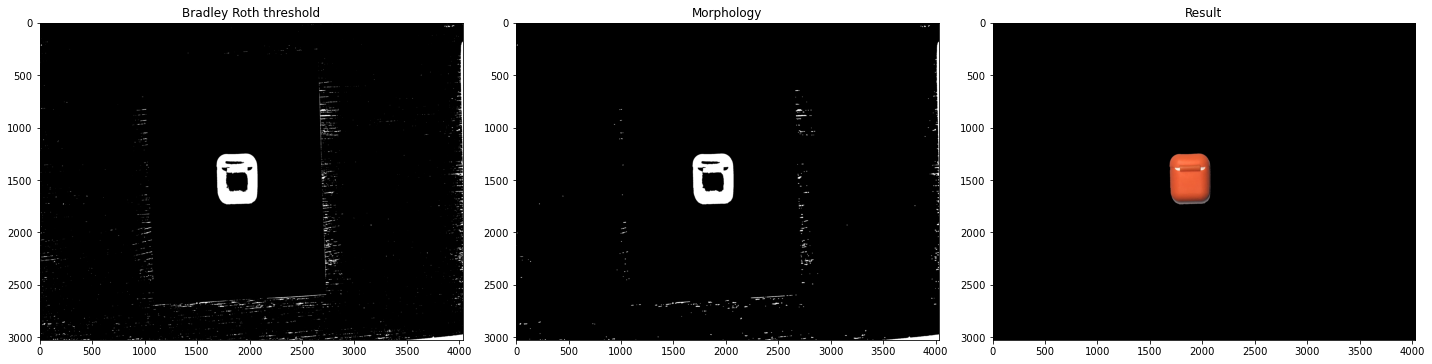

In [55]:
image_path = os.path.join('input\objects', '2.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 1), int(image.shape[0] * 1)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component_by_num(bradley_roth_res_enclosed, 0) # убираем лишнее вне предмета

result_mask = binary_fill_holes(object_mask) # убираем лишнее внутри предмета

result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
# ax[2].imshow(result_mask, cmap='gray')
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()
# imsave('input\\objects\\masks\\2.jpeg', result)

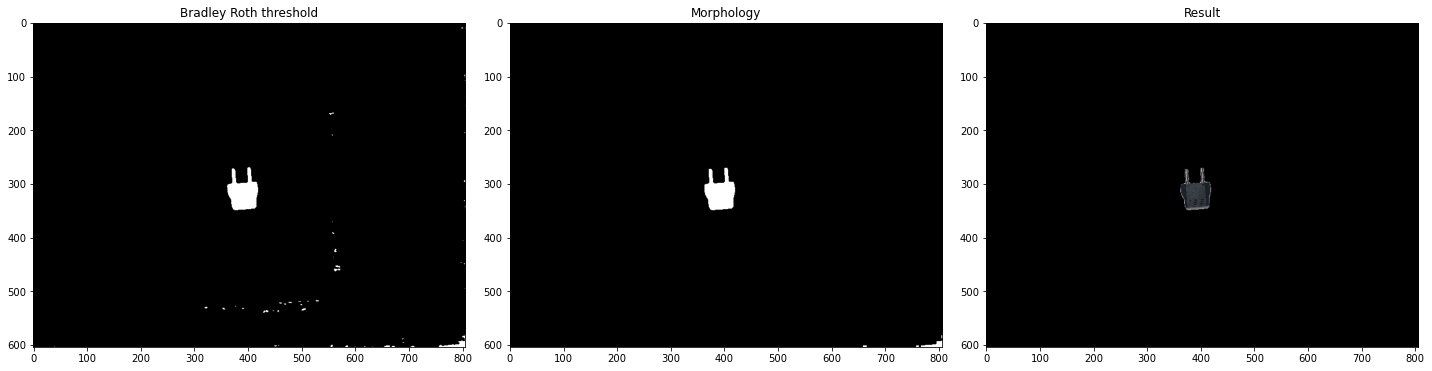

In [165]:
image_path = os.path.join('input\objects', '3.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component_by_num(bradley_roth_res_enclosed, 0) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component_by_num(inverted_object_mask, 0) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

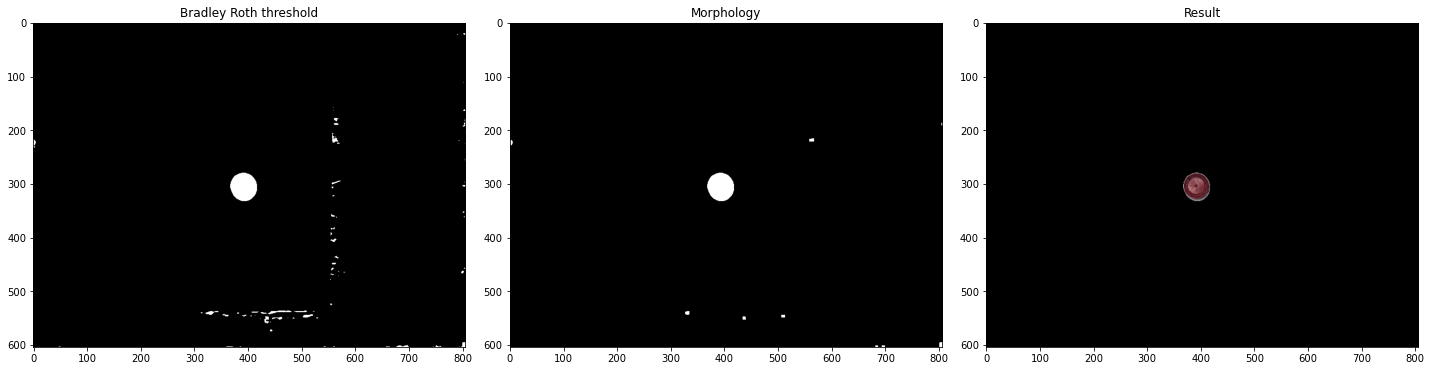

In [167]:
image_path = os.path.join('input\objects', '4.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component_by_num(bradley_roth_res_enclosed, 0) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component_by_num(inverted_object_mask, 0) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

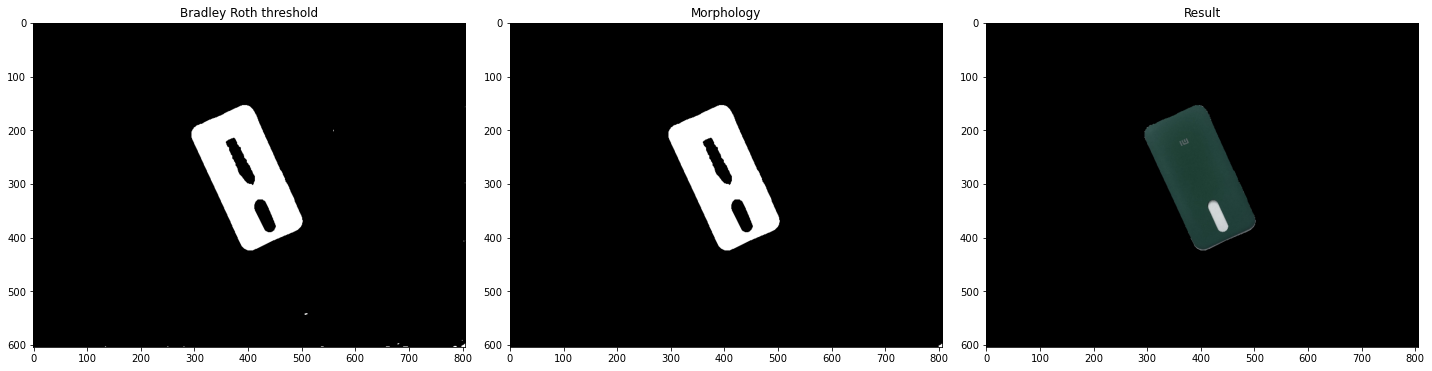

In [168]:
image_path = os.path.join('input\objects', '5.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component_by_num(bradley_roth_res_enclosed, 0) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component_by_num(inverted_object_mask, 0) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

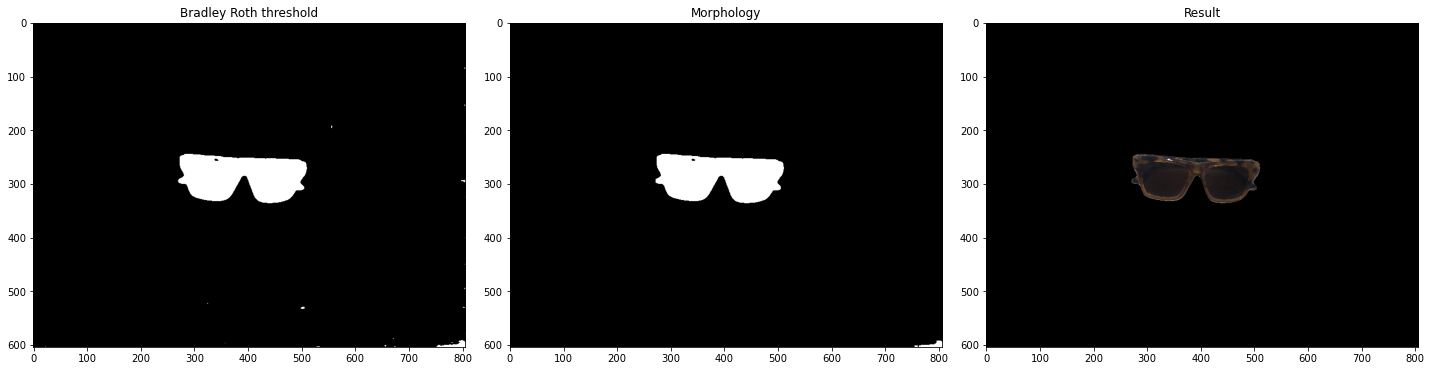

In [169]:
image_path = os.path.join('input\objects', '6.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component_by_num(bradley_roth_res_enclosed, 0) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component_by_num(inverted_object_mask, 0) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

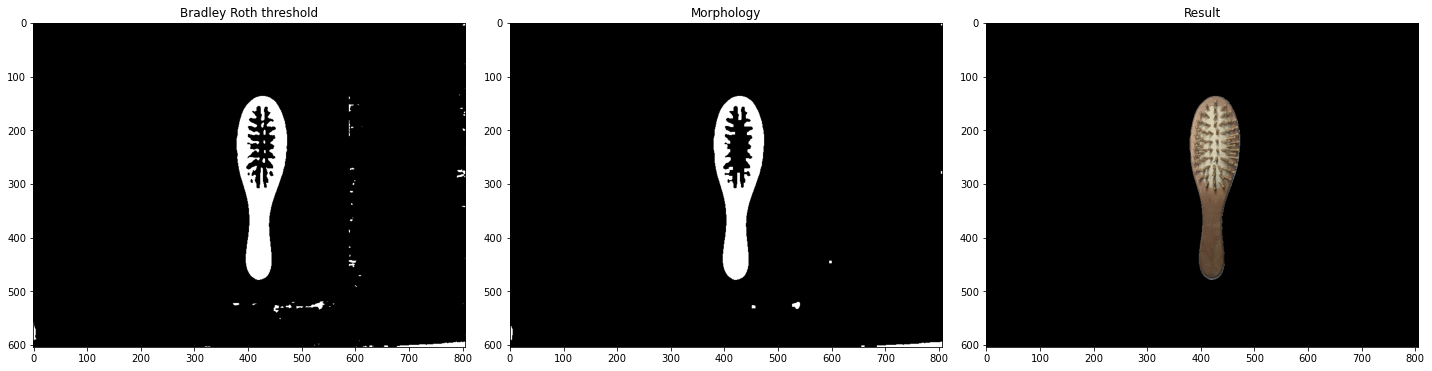

In [170]:
image_path = os.path.join('input\objects', '7.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component_by_num(bradley_roth_res_enclosed, 0) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component_by_num(inverted_object_mask, 0) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

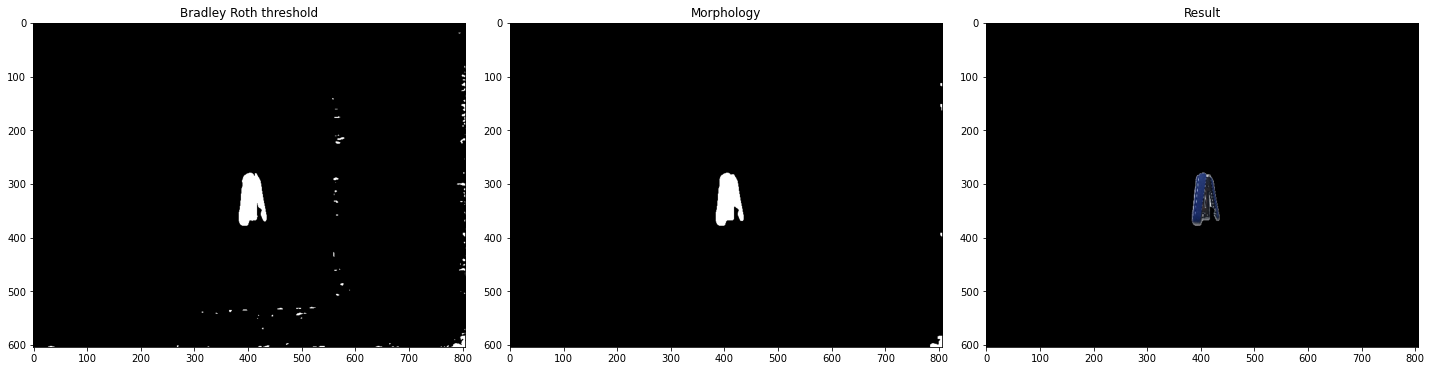

In [171]:
image_path = os.path.join('input\objects', '8.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component_by_num(bradley_roth_res_enclosed, 0) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component_by_num(inverted_object_mask, 0) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

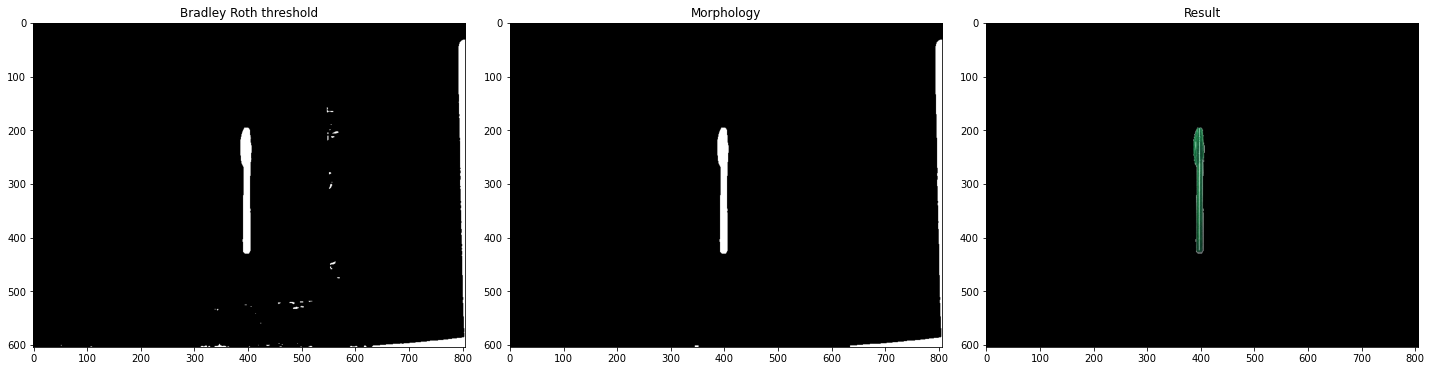

In [192]:
image_path = os.path.join('input\objects', '9.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

# убираем лишнее вне предмета, ручка - вторая по величине компонента, используем модифицированную функцию
object_mask = get_largest_component_by_num(bradley_roth_res_enclosed, 1)
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component_by_num(inverted_object_mask, 0) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

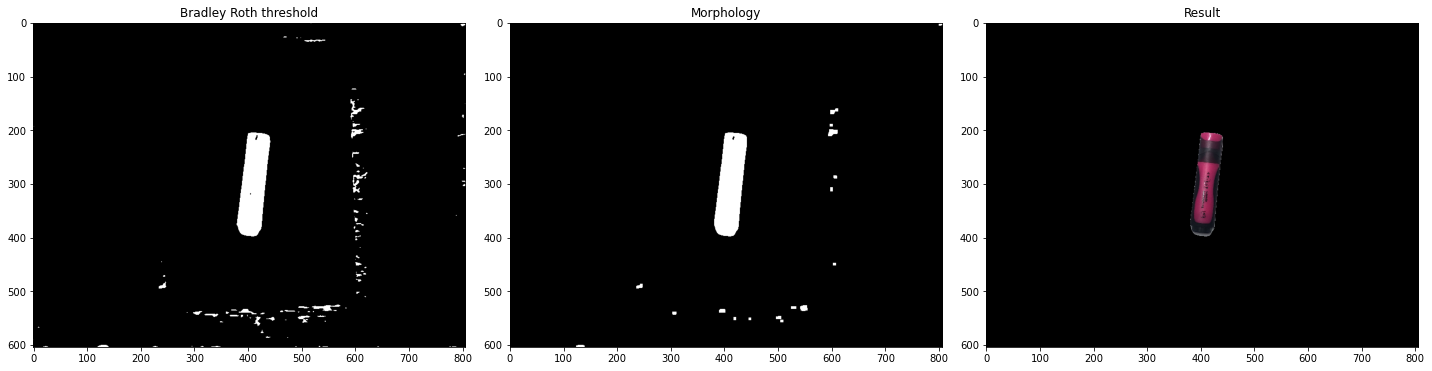

In [260]:
image_path = os.path.join('input\objects', '10.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Используем алгоритм определения порога Брэдли-Рота
bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))
ax[0].imshow(bradley_roth_res, cmap='gray')

bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1].imshow(bradley_roth_res_enclosed, cmap='gray')

object_mask = get_largest_component_by_num(bradley_roth_res_enclosed, 0) # убираем лишнее вне предмета
inverted_object_mask =  1 - object_mask
result_mask = 1 - get_largest_component_by_num(inverted_object_mask, 0) # убираем лишнее внутри предмета
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
ax[2].imshow(result, cmap='gray')

for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Result"]):
    ax[i].set_title(title)
    
fig.tight_layout()

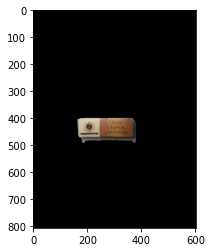

In [37]:
image_path = os.path.join('input\objects', '1_1.jpeg')
image = imread(image_path)

# Сожмем изображение для ускорения работы с ним
compressed_image = cv2.resize(image, [int(image.shape[1] * 0.2), int(image.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_image = gaussian(compressed_image, sigma=1.5, channel_axis=2)
gray_image = rgb2gray(filtered_image)

# Используем локальное пороговое значение, полученное с помощью фильтра Гаусса
background_threshold = threshold_local(gray_image, 37, method='gaussian')
threshold_res = gray_image >= background_threshold

threshold_res_enclosed_inside = binary_erosion(binary_dilation(threshold_res))
threshold_res_enclosed = binary_opening(threshold_res_enclosed_inside, footprint=np.ones((7, 7)))

# Используя модифицированную функцию, выбираем вторую по площади компоненту вокруг объекта
result_mask = get_largest_component_by_num(1 - get_largest_component_by_num(threshold_res_enclosed, 1), 1)
result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
plt.imshow(result, cmap='gray')

# # Используем алгоритм определения порога Брэдли-Рота
# bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(gray_image))

# bradley_roth_res_enclosed_inside = binary_erosion(binary_dilation(bradley_roth_res))
# bradley_roth_res_enclosed = binary_opening(bradley_roth_res_enclosed_inside, footprint=np.ones((5, 5)))

# object_mask = get_largest_component(bradley_roth_res_enclosed) # убираем лишнее вне предмета
# inverted_object_mask =  1 - object_mask
# result_mask = 1 - get_largest_component(inverted_object_mask) # убираем лишнее внутри предмета
# result = cv2.bitwise_and(compressed_image, compressed_image, mask=result_mask.astype("uint8"))
# plt.imshow(result, cmap='gray')
    
fig.tight_layout()

# Сохранение полученного изображения в файл
binarization_result = os.path.join("input\objects\masks", "1_1_mask.png")
plt.savefig(binarization_result)

## Получим маски для поверхности, чтобы далее отделять предметы и многоугольник

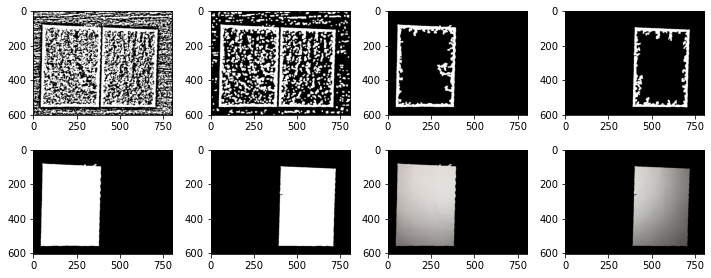

In [54]:
background_path = os.path.join('input\\tests', 'background.jpeg')
background = imread(background_path)

compressed_background = cv2.resize(background, [int(background.shape[1] * 0.2), int(background.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_background = gaussian(compressed_background, sigma=1.5, channel_axis=2)
gray_background = rgb2gray(filtered_background)

fig, ax = plt.subplots(2, 4, figsize=(10, 4))

background_threshold = threshold_local(gray_background, 47, method='gaussian')
threshold_res = gray_background >= background_threshold
ax[0, 0].imshow(threshold_res, cmap="gray")

threshold_res_enclosed_inside = binary_erosion(binary_dilation(threshold_res))
threshold_res_enclosed = binary_opening(threshold_res_enclosed_inside, footprint=np.ones((7, 7)))
ax[0, 1].imshow(threshold_res_enclosed, cmap="gray")

# Используя модифицированную функцию, выбираем две наибольшие по площади компоненты связности
component_of_left_sheet = get_largest_component_by_num(threshold_res_enclosed, 0)
component_of_right_sheet = get_largest_component_by_num(threshold_res_enclosed, 1)
ax[0, 2].imshow(component_of_left_sheet, cmap="gray")
ax[0, 3].imshow(component_of_right_sheet, cmap="gray")

left_sheet_mask = binary_fill_holes(component_of_left_sheet).astype("uint8")
right_sheet_mask = binary_fill_holes(component_of_right_sheet).astype("uint8")

ax[1, 0].imshow(left_sheet_mask, cmap="gray")
ax[1, 1].imshow(right_sheet_mask, cmap="gray")

ax[1, 2].imshow(cv2.bitwise_and(compressed_background,compressed_background,mask = left_sheet_mask), cmap="gray")
ax[1, 3].imshow(cv2.bitwise_and(compressed_background,compressed_background,mask = right_sheet_mask), cmap="gray")

fig.tight_layout()

Используя полученный для изображения с пустыми листами алгоритм, разделим тестовые изображения на два, соответствующих левому и правому листу. Так как для выделения компонент листов используется метод get_largest_component_by_num(), результат работы которого зависит от ракурса изображения, полученные маски не обязательно будут соответствовать листам в порядке слева направо. Для правильного разделения на лист с предметами и лист с многоугольником будем далее сравнивать интенсивности пикселей изображений, полученных в результате применения масок.

Посмотрим на примере одного из тестовых изображений, какой фильтр лучше для определения порога.

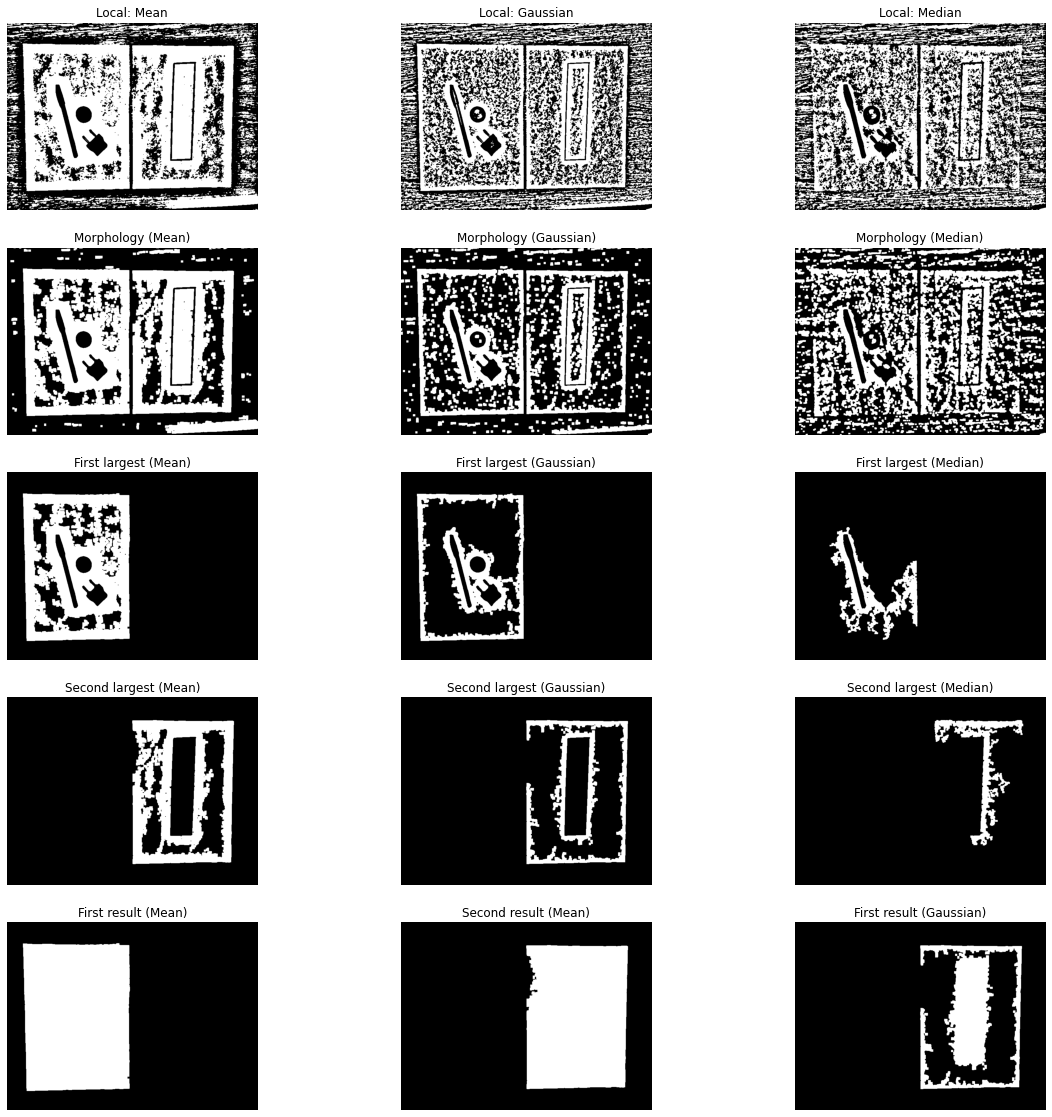

In [59]:
input_path = os.path.join('input\\tests', '01True.jpeg')
input_img = imread(input_path)

compressed_input = cv2.resize(input_img, [int(input_img.shape[1] * 0.2), int(input_img.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_input = gaussian(compressed_input, sigma=1, channel_axis=2)
gray_input = rgb2gray(filtered_input)

fig, ax = plt.subplots(5, 3, figsize=(20, 20))

mean_input = gray_input >= threshold_local(gray_input, 63, method='mean')
gaussian_input = gray_input >= threshold_local(gray_input, 41, method='gaussian')
median_input = gray_input >= threshold_local(gray_input, 41, method='median')
ax[0, 0].imshow(mean_input, cmap='gray')
ax[0, 1].imshow(gaussian_input, cmap='gray')
ax[0, 2].imshow(median_input, cmap='gray')
for j in range(5):
    for i in range(3): ax[j, i].set_axis_off()

for i, title in enumerate(["Local: Mean", "Local: Gaussian", "Local: Median"]): ax[0, i].set_title(title)
    
mean_threshold_res_enclosed_inside = binary_erosion(binary_dilation(mean_input))
mean_threshold_res_enclosed = binary_opening(mean_input, footprint=np.ones((7, 7)))
ax[1, 0].imshow(mean_threshold_res_enclosed, cmap="gray")

gaussian_threshold_res_enclosed_inside = binary_erosion(binary_dilation(gaussian_input))
gaussian_threshold_res_enclosed = binary_opening(gaussian_threshold_res_enclosed_inside, footprint=np.ones((7, 7)))
ax[1, 1].imshow(gaussian_threshold_res_enclosed, cmap="gray")

median_threshold_res_enclosed_inside = binary_erosion(binary_dilation(median_input))
median_threshold_res_enclosed = binary_opening(median_threshold_res_enclosed_inside, footprint=np.ones((5, 5)))
ax[1, 2].imshow(median_threshold_res_enclosed, cmap="gray")

for i, title in enumerate(["Morphology (Mean)", "Morphology (Gaussian)", "Morphology (Median)"]): ax[1, i].set_title(title)
    
# Используя модифицированную функцию, выбираем две наибольшие по площади компоненты связности
mean_component_of_first_sheet = get_largest_component_by_num(mean_threshold_res_enclosed, 0)
ax[2, 0].imshow(mean_component_of_first_sheet, cmap="gray")
gaussian_component_of_first_sheet = get_largest_component_by_num(gaussian_threshold_res_enclosed, 0)
ax[2, 1].imshow(gaussian_component_of_first_sheet, cmap="gray")
median_component_of_first_sheet = get_largest_component_by_num(median_threshold_res_enclosed, 0)
ax[2, 2].imshow(median_component_of_first_sheet, cmap="gray")

for i, title in enumerate(["First largest (Mean)", "First largest (Gaussian)", "First largest (Median)"]): ax[2, i].set_title(title)

mean_component_of_second_sheet = get_largest_component_by_num(mean_threshold_res_enclosed, 1)
ax[3, 0].imshow(mean_component_of_second_sheet, cmap="gray")
gaussian_component_of_second_sheet = get_largest_component_by_num(gaussian_threshold_res_enclosed, 1)
ax[3, 1].imshow(gaussian_component_of_second_sheet, cmap="gray")
median_component_of_second_sheet = get_largest_component_by_num(median_threshold_res_enclosed, 1)
ax[3, 2].imshow(median_component_of_second_sheet, cmap="gray")

for i, title in enumerate(["Second largest (Mean)", "Second largest (Gaussian)", "Second largest (Median)"]): ax[3, i].set_title(title)

ax[4, 0].imshow(binary_fill_holes(mean_component_of_first_sheet), cmap="gray")
ax[4, 1].imshow(binary_fill_holes(mean_component_of_second_sheet), cmap="gray")
ax[4, 2].imshow(binary_fill_holes(gaussian_component_of_second_sheet), cmap="gray")

for i, title in enumerate(["First result (Mean)", "Second result (Mean)", "First result (Gaussian)"]): ax[4, i].set_title(title)

Видим, что фильтр Гаусса не всегда позволяет выделить замкнутую компоненту листа. Поменяем фильтр и применим алгоритм на части тестовых данных. Обрежем все изображения по ограничивающим прямоугольникам компонент связности листов.

In [51]:
def get_bound_boxes(mask):
    labels = sk_measure_label(mask) # разбиение маски на компоненты связности
    props = regionprops(labels) # нахождение свойств каждой области
    bboxs = [prop.bbox for prop in props]
    
    return bboxs

C:\Temp\ipykernel_11872\2966538129.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 4, figsize=(10, 10))


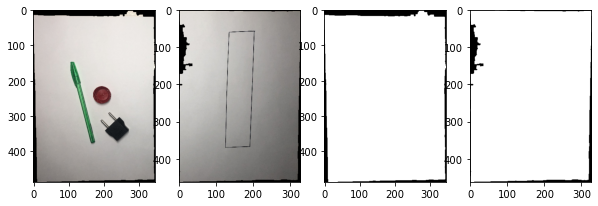

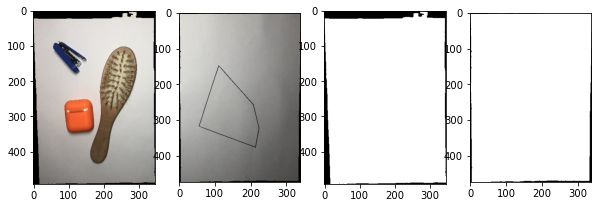

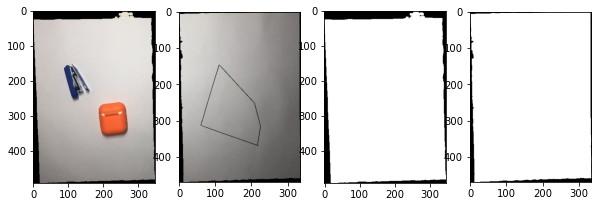

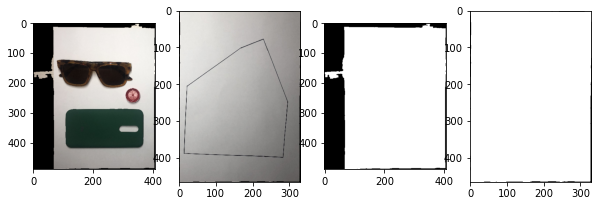

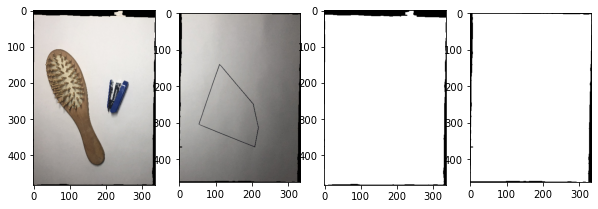

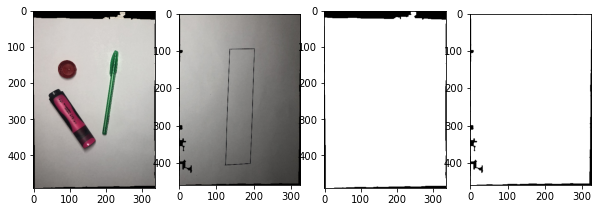

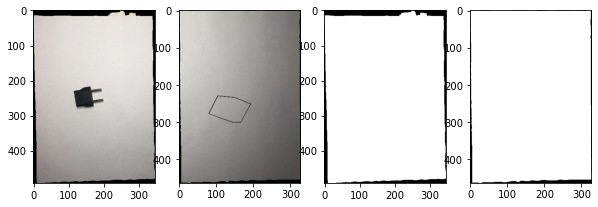

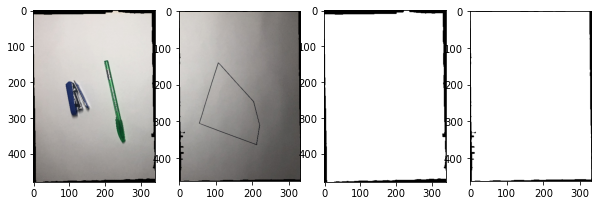

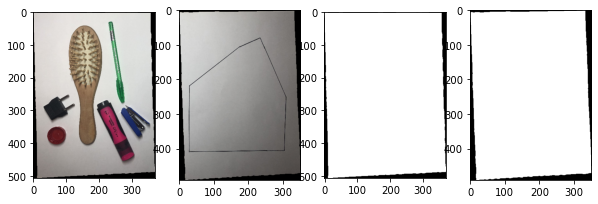

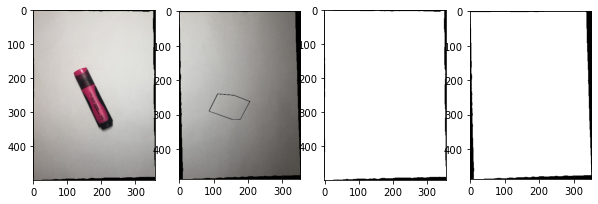

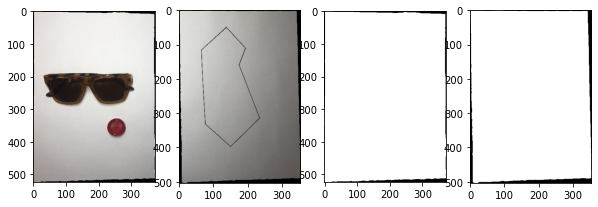

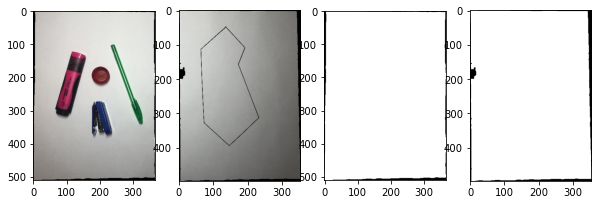

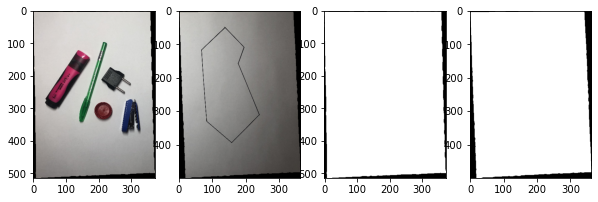

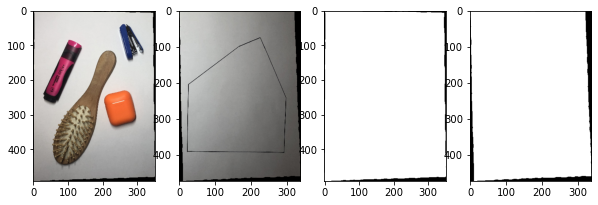

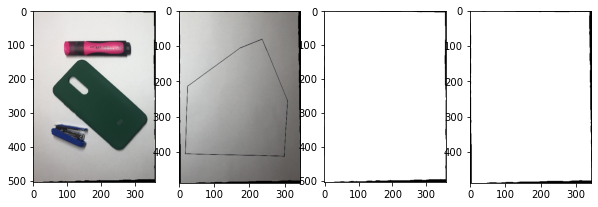

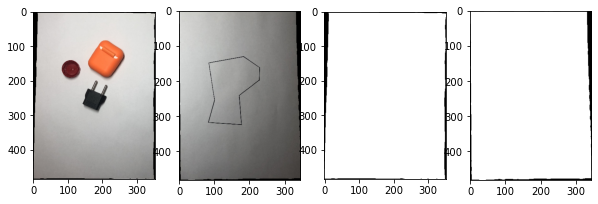

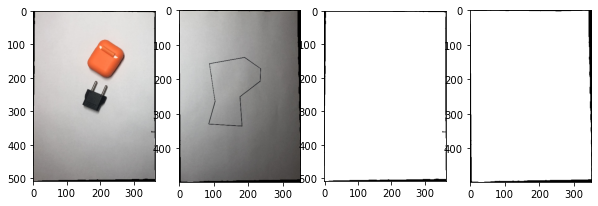

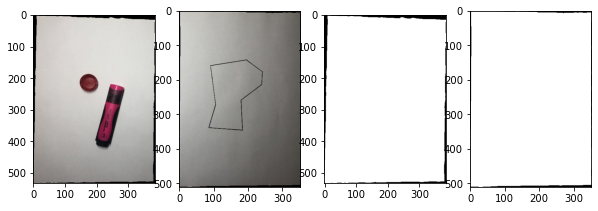

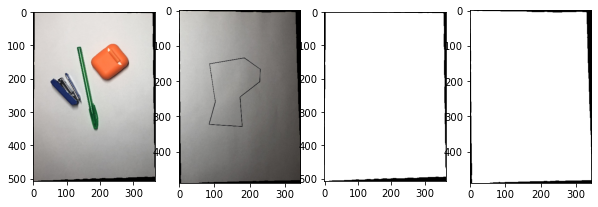

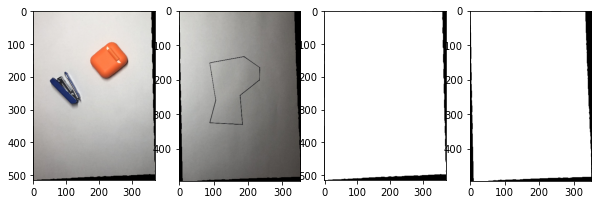

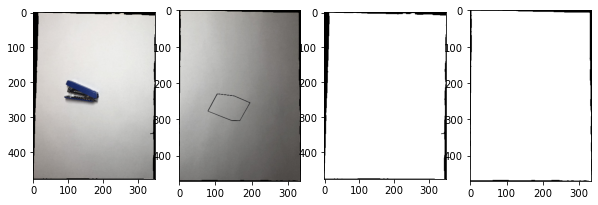

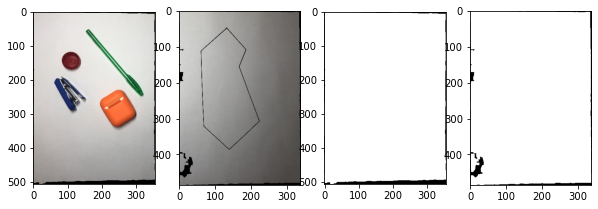

In [60]:
names = ['01True.jpeg', '02False.jpeg', '03True.jpeg', '05True.jpeg', '06False.jpeg', '07True.jpeg', '09True.jpeg', '10True.jpeg', '11True.jpeg', '12False.jpeg', '13True.jpeg', '14True.jpeg', '15True.jpeg',
 '16True.jpeg', '17True.jpeg', '18True.jpeg', '19True.jpeg', '20True.jpeg', '21False.jpeg', '22True.jpeg', '23False.jpeg',
 '24True.jpeg']
# names = ['01True.jpeg']
for name in names:
    input_path = os.path.join('input\\tests', name)
    input_img = imread(input_path)
    
    compressed_input = cv2.resize(input_img, [int(input_img.shape[1] * 0.2), int(input_img.shape[0] * 0.2)], cv2.INTER_AREA)
    filtered_input = gaussian(compressed_input, sigma=1, channel_axis=2)
    gray_input = rgb2gray(filtered_input)
    
    fig, ax = plt.subplots(1, 4, figsize=(10, 10))
    mean_input = gray_input >= threshold_local(gray_input, 63, method='mean')
    
    threshold_res_enclosed_inside = binary_erosion(binary_dilation(mean_input))
    threshold_res_enclosed = binary_opening(threshold_res_enclosed_inside, footprint=np.ones((7, 7)))
    
    # Используя модифицированную функцию, выбираем две наибольшие по площади компоненты связности
    sheets_masks = [get_largest_component_by_num(threshold_res_enclosed, 0), 
                         get_largest_component_by_num(threshold_res_enclosed, 1)]
    masks_bound_boxes = [get_bound_boxes(sheets_masks[0])[0], get_bound_boxes(sheets_masks[1])[0]]
    
    sheets_by_masks = []
    for i in range(2):
        sheets_masks[i] = binary_fill_holes(sheets_masks[i]).astype("uint8")
        sheets_by_masks.append(cv2.bitwise_and(compressed_input,compressed_input,mask = sheets_masks[i]))
        
        # Обрезаем маску и полученное по ней изображение листа
        sheets_masks[i] = rectangular_crop_image(sheets_masks[i], masks_bound_boxes[i], 0)
        sheets_by_masks[i] = rectangular_crop_image(sheets_by_masks[i], masks_bound_boxes[i], 0)
    
    ax[2].imshow(sheets_masks[0], cmap="gray")
    ax[3].imshow(sheets_masks[1], cmap="gray")

    ax[0].imshow(sheets_by_masks[0])
    ax[1].imshow(sheets_by_masks[1])

Применим алгоритм бинаризации Брэдли-Рота, полученные маски применим к обрезанным изображениям.

mean:  0.6923047727581885 , standard deviation: 0.2698873320744084
mean:  0.5932656131030295 , standard deviation: 0.1980950679081954


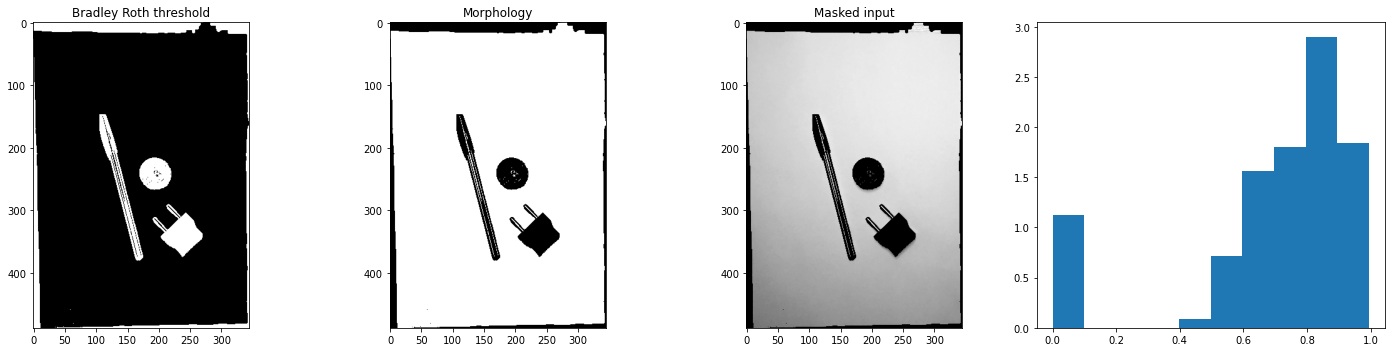

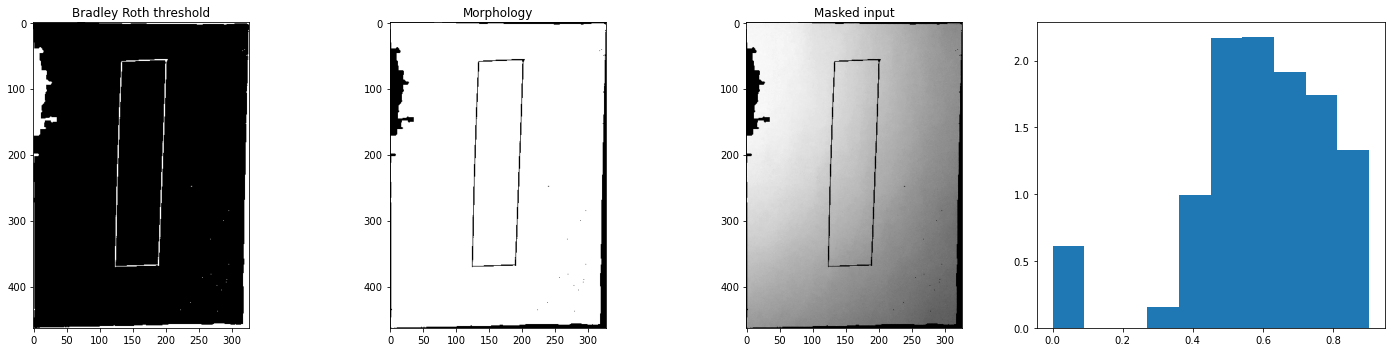

In [67]:
input_path = os.path.join('input\\tests', '01True.jpeg')
input_img = imread(input_path)
compressed_input = cv2.resize(input_img, [int(input_img.shape[1] * 0.2), int(input_img.shape[0] * 0.2)], cv2.INTER_AREA)
filtered_input = gaussian(compressed_input, sigma=1, channel_axis=2)
gray_input = rgb2gray(filtered_input)
    
mean_input = gray_input >= threshold_local(gray_input, 63, method='mean')
    
threshold_res_enclosed_inside = binary_erosion(binary_dilation(mean_input))
threshold_res_enclosed = binary_opening(threshold_res_enclosed_inside, footprint=np.ones((7, 7)))
    
# Используя модифицированную функцию, выбираем две наибольшие по площади компоненты связности
sheets_masks = [get_largest_component_by_num(threshold_res_enclosed, 0), 
                get_largest_component_by_num(threshold_res_enclosed, 1)]
masks_bound_boxes = [get_bound_boxes(sheets_masks[0])[0], get_bound_boxes(sheets_masks[1])[0]]

sheets_by_masks = []
for i in range(2):
    sheets_masks[i] = binary_fill_holes(sheets_masks[i]).astype("uint8")
    sheets_by_masks.append(cv2.bitwise_and(compressed_input,compressed_input,mask = sheets_masks[i]))

    # Обрезаем маску и полученное по ней изображение листа
    sheets_masks[i] = rectangular_crop_image(sheets_masks[i], masks_bound_boxes[i], 0)
    sheets_by_masks[i] = rectangular_crop_image(sheets_by_masks[i], masks_bound_boxes[i], 0)    
    
for sheet in sheets_by_masks:
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
       
    # Используем алгоритм определения порога Брэдли-Рота
    bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(rgb2gray(sheet)))
    ax[0].imshow(bradley_roth_res, cmap='gray')

    bradley_roth_res_enclosed = binary_opening(bradley_roth_res, footprint=np.ones((1, 1)))
    ax[1].imshow(1 - bradley_roth_res_enclosed, cmap='gray')
    
    input_mask = (1 - bradley_roth_res_enclosed).astype("uint8")
    input_by_mask = rgb2gray(cv2.bitwise_and(sheet,sheet,mask = input_mask))

    print("mean: ", np.mean(input_by_mask.flatten()),", standard deviation:", np.std(input_by_mask.flatten()))
    ax[2].imshow(input_by_mask, cmap='gray')
    ax[3].hist(input_by_mask.ravel(), density=True)

    for i, title in enumerate(["Bradley Roth threshold", "Morphology", "Masked input"]):
        ax[i].set_title(title)
    
    fig.tight_layout()

Из-за наложения маски на предметы количество пикселей черного цвета на изображении с предметами значительно увеличилось относительно изображения с многоугольником(при этом часть из них на изображении с многоугольником вообще относятся к погрешности получения маски). Значение среднего может сильно зависеть от освещения на входной фотографии, поэтому будем ориентироваться на среднеквадратическое отклонение.

Проверим на части тестовых данных.

01True.jpeg
mean:  0.6923047727581885 , standard deviation: 0.2698873320744084
mean:  0.5932656131030295 , standard deviation: 0.1980950679081954
02False.jpeg
mean:  0.587485642925628 , standard deviation: 0.3195010922680389
mean:  0.5682899597869668 , standard deviation: 0.18758917135483294
03True.jpeg
mean:  0.6506161932503374 , standard deviation: 0.2818653758058255
mean:  0.5585093797694881 , standard deviation: 0.19842513908546305
04True.jpeg
mean:  0.5545316030065814 , standard deviation: 0.34145458062611556
mean:  0.6055494123798539 , standard deviation: 0.1733276818546492
05True.jpeg
mean:  0.45445557191349445 , standard deviation: 0.4071134280683007
mean:  0.6527374750024862 , standard deviation: 0.177002010609746
06False.jpeg
mean:  0.6527541969807245 , standard deviation: 0.3083873973348772
mean:  0.5468390384426008 , standard deviation: 0.19417490704031257
07True.jpeg
mean:  0.6302681906715066 , standard deviation: 0.26424312856529375
mean:  0.4853489148350711 , standard de

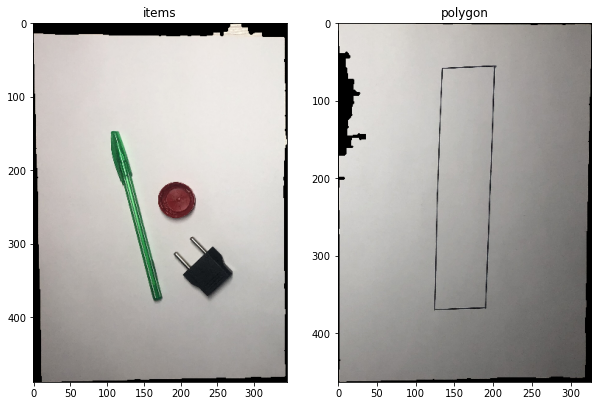

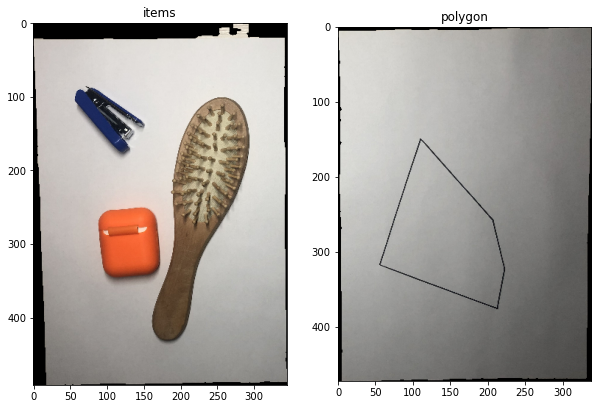

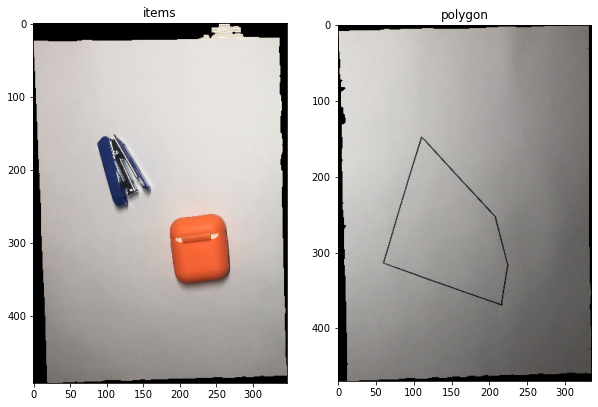

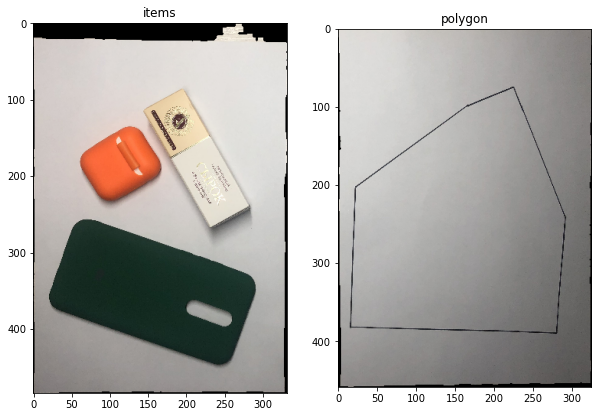

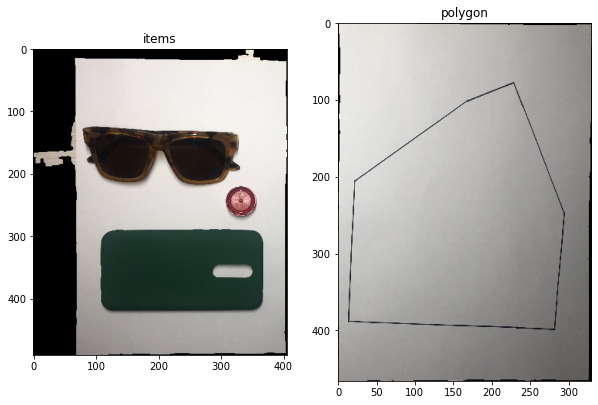

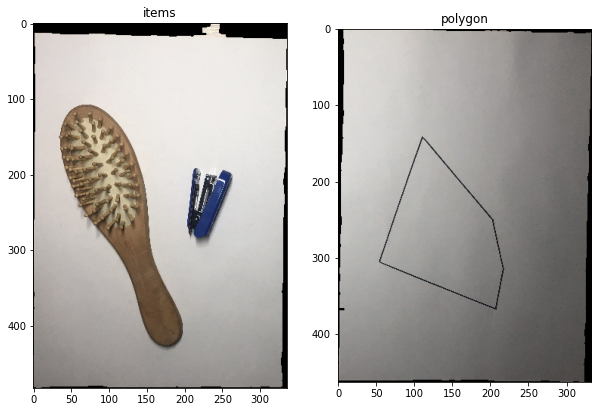

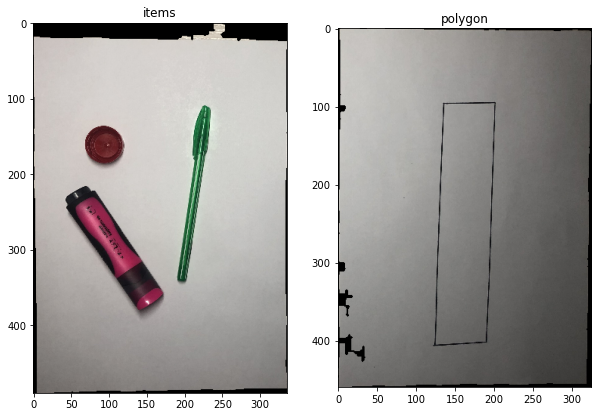

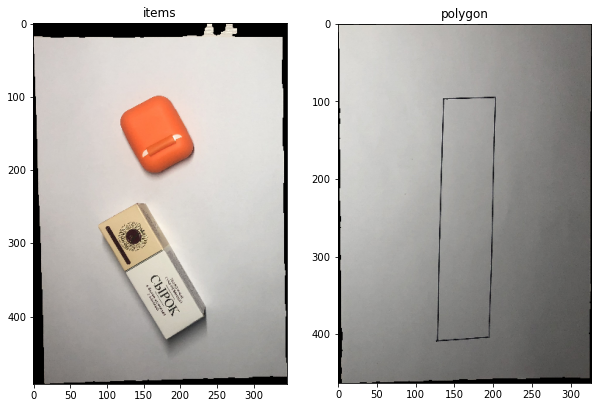

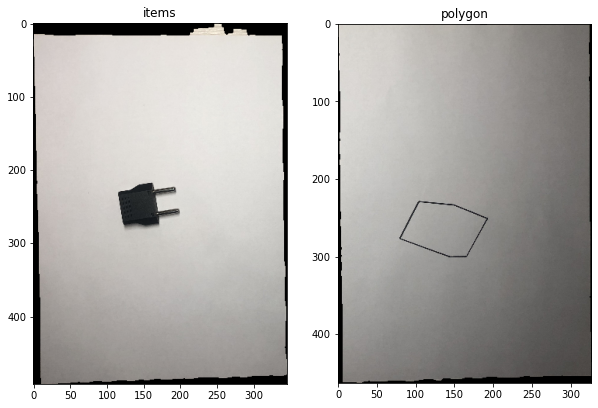

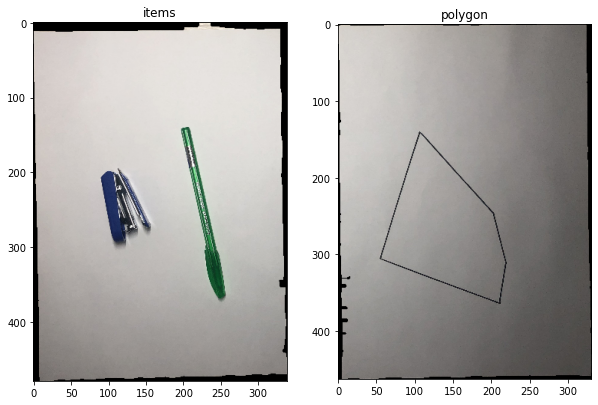

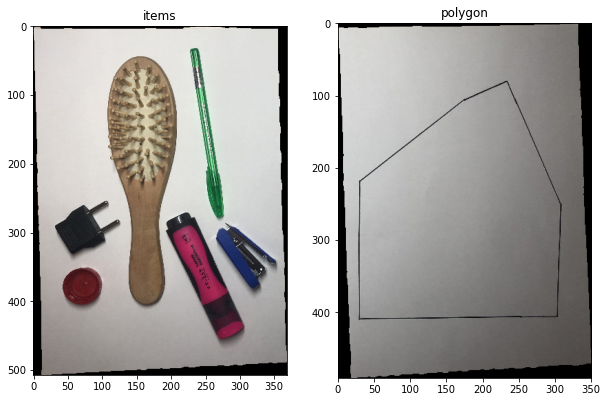

In [115]:
names = ['01True.jpeg', '02False.jpeg', '03True.jpeg', '04True.jpeg', '05True.jpeg', '06False.jpeg', '07True.jpeg', '08False.jpeg',
 '09True.jpeg', '10True.jpeg']
for name in names:
    std = np.array([])
    input_path = os.path.join('input\\tests', name)
    input_img = imread(input_path)
    compressed_input = cv2.resize(input_img, [int(input_img.shape[1] * 0.2), int(input_img.shape[0] * 0.2)], cv2.INTER_AREA)
    filtered_input = gaussian(compressed_input, sigma=1, channel_axis=2)
    gray_input = rgb2gray(filtered_input)

    mean_input = gray_input >= threshold_local(gray_input, 63, method='mean')

    threshold_res_enclosed_inside = binary_erosion(binary_dilation(mean_input))
    threshold_res_enclosed = binary_opening(threshold_res_enclosed_inside, footprint=np.ones((7, 7)))

    # Используя модифицированную функцию, выбираем две наибольшие по площади компоненты связности
    sheets_masks = [get_largest_component_by_num(threshold_res_enclosed, 0), 
                    get_largest_component_by_num(threshold_res_enclosed, 1)]
    masks_bound_boxes = [get_bound_boxes(sheets_masks[0])[0], get_bound_boxes(sheets_masks[1])[0]]

    sheets_by_masks = []
    for i in range(2):
        sheets_masks[i] = binary_fill_holes(sheets_masks[i]).astype("uint8")
        sheets_by_masks.append(cv2.bitwise_and(compressed_input,compressed_input,mask = sheets_masks[i]))

        # Обрезаем маску и полученное по ней изображение листа
        sheets_masks[i] = rectangular_crop_image(sheets_masks[i], masks_bound_boxes[i], 0)
        sheets_by_masks[i] = rectangular_crop_image(sheets_by_masks[i], masks_bound_boxes[i], 0)    

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    name = input_path[input_path.rfind("\\") + 1:]
    print(name)
    
    for i in range(2):

        # Используем алгоритм определения порога Брэдли-Рота
        bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(rgb2gray(sheets_by_masks[i])))
        bradley_roth_res_enclosed = binary_opening(bradley_roth_res, footprint=np.ones((1, 1)))

        input_mask = (1 - bradley_roth_res_enclosed).astype("uint8")
        input_by_mask = rgb2gray(cv2.bitwise_and(sheets_by_masks[i],sheets_by_masks[i],mask = input_mask))

        std = np.append(std, np.std(input_by_mask.flatten()))
        
        print("mean: ", np.mean(input_by_mask.flatten()),", standard deviation:", np.std(input_by_mask.flatten()))
        ax[i].imshow(sheets_by_masks[i], cmap='gray')

    
    if (std[0] > std[1]):
        ax[0].set_title("items")
        ax[1].set_title("polygon")
    else:
        ax[0].set_title("polygon")
        ax[1].set_title("items")            

## Сегментируем объекты на изображениях

In [11]:
def rectangular_crop_image(image, rec_points: tuple, eps):
    upper = rec_points[0]
    lower = rec_points[2]
    left = rec_points[1]
    right = rec_points[3]
    return image[upper - eps : lower + eps, left - eps : right + eps]

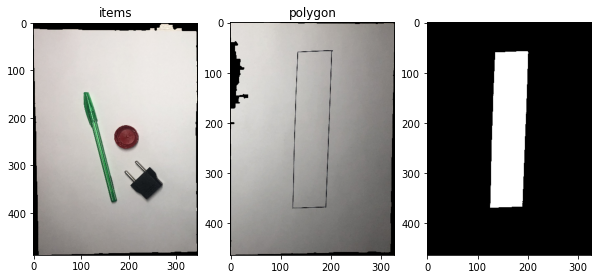

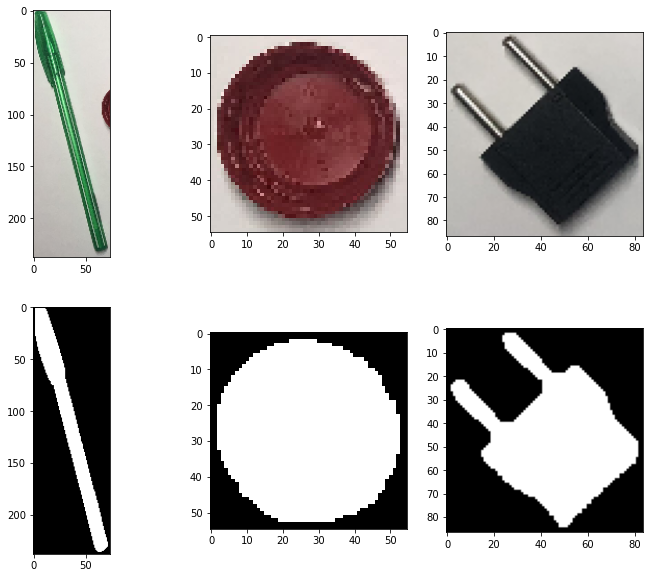

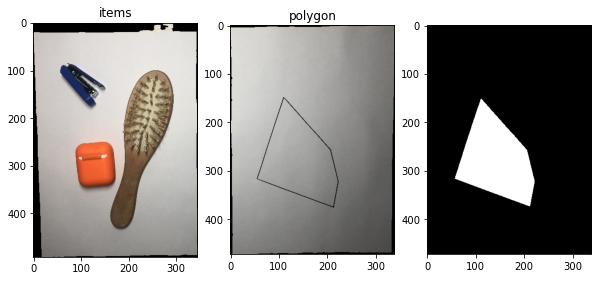

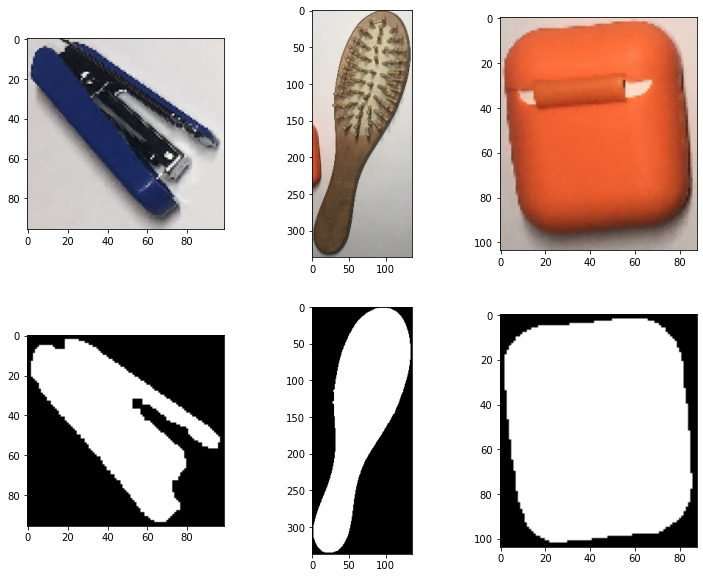

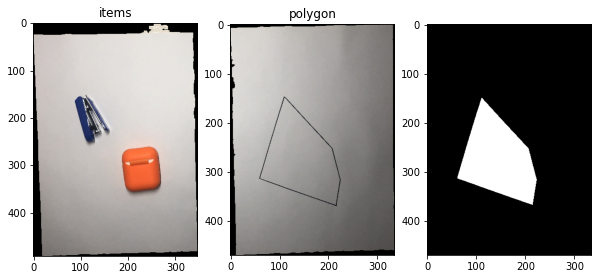

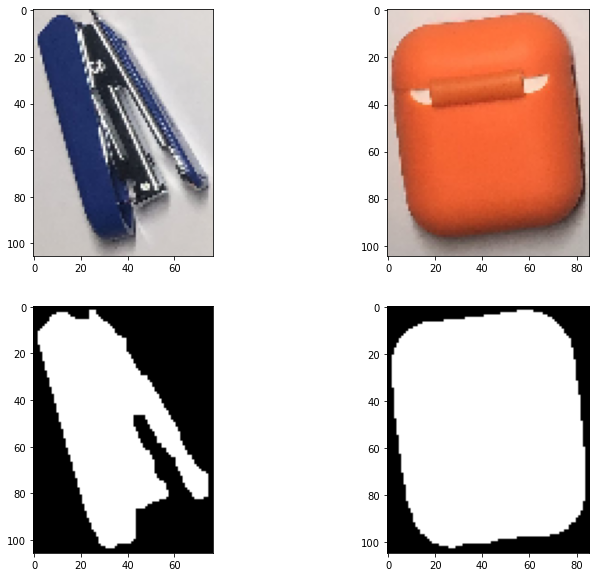

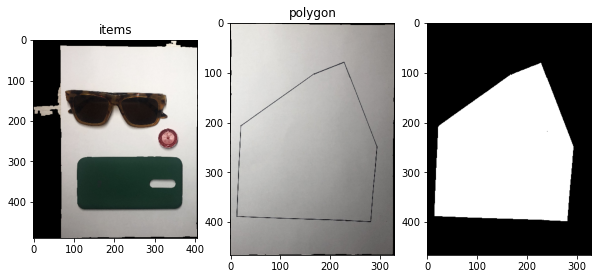

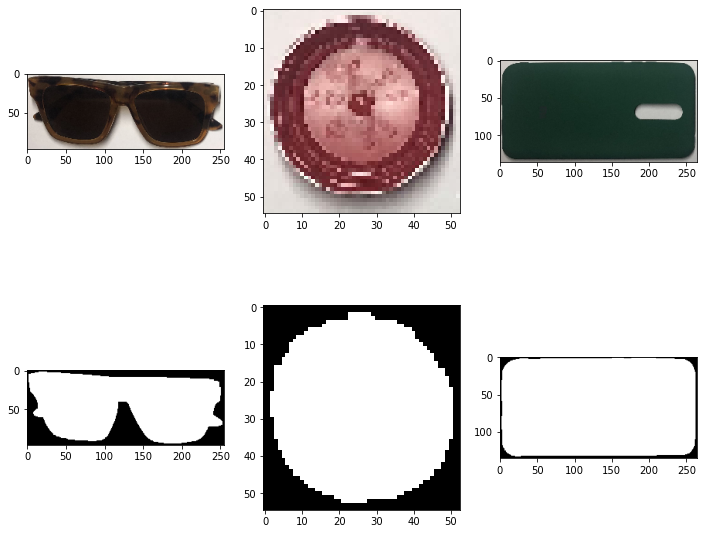

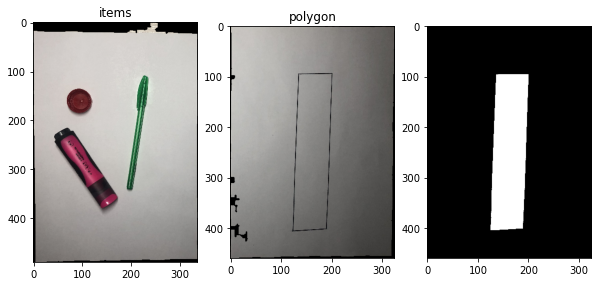

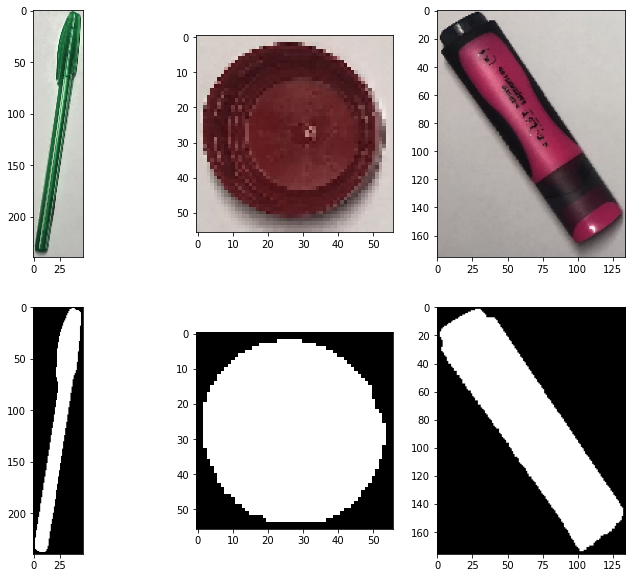

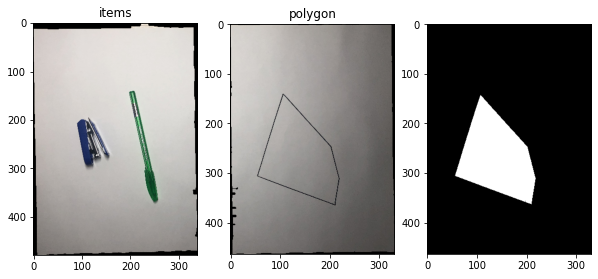

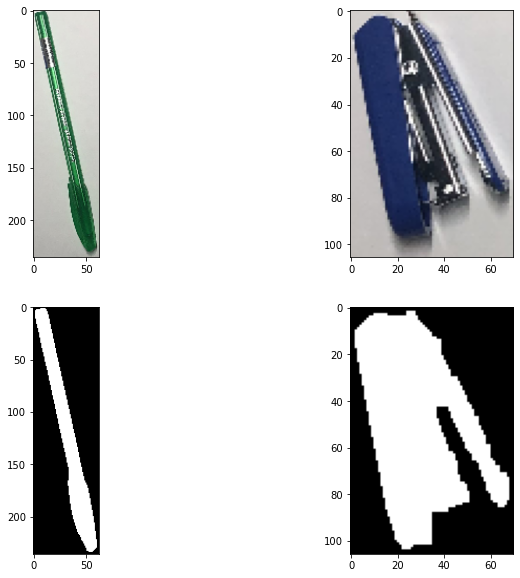

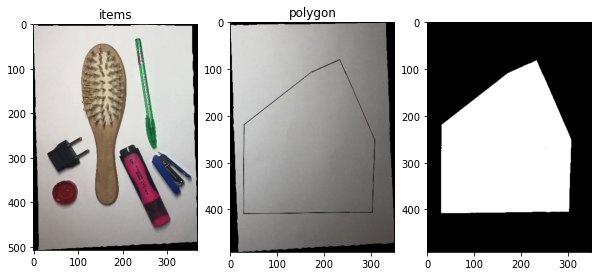

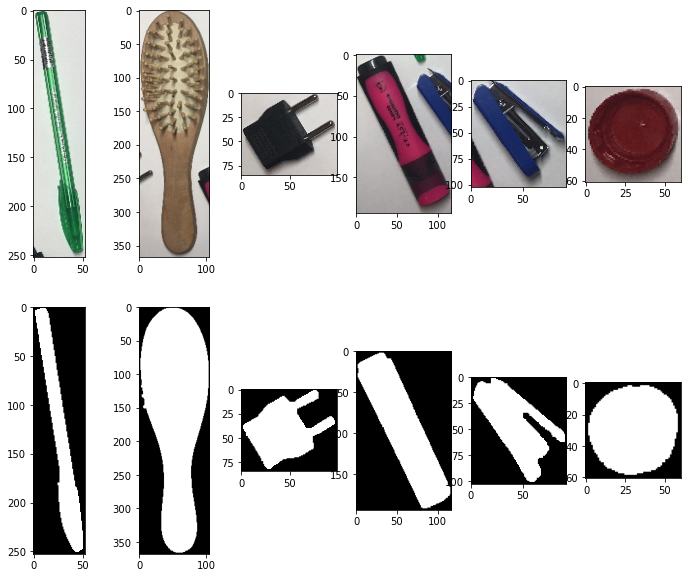

In [124]:
names = ['01True.jpeg', '02False.jpeg', '03True.jpeg', '05True.jpeg', '07True.jpeg', '10True.jpeg', '11True.jpeg']
# names = ['01True.jpeg']
for name in names:
    std = np.array([])
    input_path = os.path.join('input\\tests', name)
    input_img = imread(input_path)
    compressed_input = cv2.resize(input_img, [int(input_img.shape[1] * 0.2), int(input_img.shape[0] * 0.2)], cv2.INTER_AREA)
    filtered_input = gaussian(compressed_input, sigma=1, channel_axis=2)
    gray_input = rgb2gray(filtered_input)

    mean_input = gray_input >= threshold_local(gray_input, 63, method='mean')

    threshold_res_enclosed_inside = binary_erosion(binary_dilation(mean_input))
    threshold_res_enclosed = binary_opening(threshold_res_enclosed_inside, footprint=np.ones((7, 7)))

    # Используя модифицированную функцию, выбираем две наибольшие по площади компоненты связности
    sheets_masks = [get_largest_component_by_num(threshold_res_enclosed, 0), 
                    get_largest_component_by_num(threshold_res_enclosed, 1)]
    masks_bound_boxes = [get_bound_boxes(sheets_masks[0])[0], get_bound_boxes(sheets_masks[1])[0]]

    sheets_by_masks = []
    for i in range(2):
        sheets_masks[i] = binary_fill_holes(sheets_masks[i]).astype("uint8")
        sheets_by_masks.append(cv2.bitwise_and(compressed_input,compressed_input,mask = sheets_masks[i]))

        # Обрезаем маску и полученное по ней изображение листа
        sheets_masks[i] = rectangular_crop_image(sheets_masks[i], masks_bound_boxes[i], 0)
        sheets_by_masks[i] = rectangular_crop_image(sheets_by_masks[i], masks_bound_boxes[i], 0)    

    fig, ax = plt.subplots(1, 3, figsize=(10, 10))
    name = input_path[input_path.rfind("\\") + 1:]
    
    for i in range(2):

        # Используем алгоритм определения порога Брэдли-Рота
        bradley_roth_res = cv2.bitwise_not(bradley_roth_threshold(rgb2gray(sheets_by_masks[i])))
        bradley_roth_res_enclosed = binary_opening(bradley_roth_res, footprint=np.ones((1, 1)))

        input_mask = (1 - bradley_roth_res_enclosed).astype("uint8")
        input_by_mask = rgb2gray(cv2.bitwise_and(sheets_by_masks[i],sheets_by_masks[i],mask = input_mask))

        std = np.append(std, np.std(input_by_mask.flatten()))
        ax[i].imshow(sheets_by_masks[i], cmap='gray')
      
    if (std[0] > std[1]):
        ax[0].set_title("items")
        ax[1].set_title("polygon")
        items_sheet = sheets_by_masks[0]
        items_sheet_mask = sheets_masks[0]
        polygon_sheet = sheets_by_masks[1]
        polygon_sheet_mask = sheets_masks[1]
    else:
        ax[1].set_title("items")
        ax[0].set_title("polygon")
        items_sheet = sheets_by_masks[1]
        items_sheet_mask = sheets_masks[1]
        polygon_sheet = sheets_by_masks[0]
        polygon_sheet_mask = sheets_masks[0]

    # Выделим многоугольник
    polygon = get_largest_component_by_num(bradley_roth_threshold(rgb2gray(polygon_sheet)), 1)
#     print(regionprops(sk_measure_label(polygon))[0].area)
    ax[2].imshow(polygon, cmap="gray")


    # Выделим предметы тестового набора

    # Используем алгоритм определения порога Брэдли-Рота
    bradley_roth_res = bradley_roth_threshold(rgb2gray(items_sheet))
    bradley_roth_res_enclosed = binary_opening(bradley_roth_res, footprint=np.ones((5, 5))) # 3
    
    cropped_table = 1 - items_sheet_mask
    or_items = cv2.bitwise_or(cropped_table, bradley_roth_res_enclosed.astype(np.uint8))
    items = binary_fill_holes(1 - or_items)
    threshold_res_enclosed = remove_small_objects(binary_opening(items, footprint=np.ones((3, 3))), 100) # 4
    
    # Находим ограничивающие прямоугольники всех предметов
    boxes = get_bound_boxes(threshold_res_enclosed)
#     print(boxes)

    # Сохраним распознанные предметы и их маски в списки
    items_list = list()
    items_masks_list = list()
    
    eps = 2 # добавка к каждой стороне прямоугольника
    
    fig, ax = plt.subplots(2, len(boxes), figsize=(12, 10)) 
    for i in range(len(boxes)):
        # По координатам ограничивающего прямоугольника создаем маску 
        rec_points = np.int32([[boxes[i][1] - eps, boxes[i][0] - eps], [boxes[i][1] - eps, boxes[i][2] + eps],
                        [boxes[i][3] + eps, boxes[i][2] + eps], [boxes[i][3] + eps, boxes[i][0] - eps]])
        rec_mask = np.zeros(items_sheet.shape[0:2], dtype=np.uint8)
        rec_mask = cv2.drawContours(rec_mask, [rec_points], -1, (255, 255, 255), -1, cv2.LINE_AA)
        
        # Применяем маску и обрезаем по прямоугольнику
        item_cropped = rectangular_crop_image(cv2.bitwise_and(items_sheet, items_sheet, mask=rec_mask), boxes[i], eps)
        items_list.append(item_cropped)
        item_mask_cropped = get_largest_component_by_num(rectangular_crop_image(threshold_res_enclosed, boxes[i], eps), 0)
        items_masks_list.append(item_mask_cropped)

        ax[0, i].imshow(item_cropped, cmap="gray")
        ax[1, i].imshow(item_mask_cropped, cmap="gray")

Алгоритм поиска многоугольника требует доработки...